# Praca domowa 3
#### Ilona Bednarz

## Odtworzenie modelu z PD1

### Zmienna objaśniana:
S1 - Are you married?

### Wybrane zmienne objaśniające:

#### numeryczne:

* Q16: How many of your relatives do you see in person at least once a month?  - numeryczna

* pphhsize: Household Size

#### binarne:

* hcm2017q24_church: met in or through church or religious organization

* w6_otherdate_all: In past yr have you met anyone for dating romance or sex (not incl current partner)

### Zbudowany model:
RandomForest

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
import warnings
import waterfall_chart
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

df = pd.read_stata('dane/HCMST_2017.dta')

# wybor zmiennych
X = df[['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']].copy()
y = df['S1'].copy()

# przygotowanie danych
X['w6_otherdate_all'] = X['w6_otherdate_all'].replace('Refused', np.nan)
y = y[np.sum(X.isna(), axis=1) == 0]
X = X.dropna(axis=0).reset_index(drop=True)
bin_columns = ["hcm2017q24_church", "w6_otherdate_all"]
dummies = pd.get_dummies(X[bin_columns]).iloc[:, [1, 4]]
dummies.columns = bin_columns
X[bin_columns] = dummies
y = pd.get_dummies(y).iloc[:, 0].reset_index(drop=True) # 1 == married

# dopasowanie modelu
clf = RandomForestClassifier(n_jobs=4, n_estimators=600, random_state=123, max_depth=4)
clf.fit(X, y)
print("Istotność zmiennych:\n", dict(zip(X.columns, clf.feature_importances_)))

Istotność zmiennych:
 {'w6_otherdate_all': 0.38528437824086864, 'hcm2017q24_church': 0.056442964879984056, 'pphhsize': 0.46301484989720204, 'Q16': 0.09525780698194539}


## Rozwiązanie PD3

In [35]:
def plot_variable_attribution(variables, vals, model, X):
    baseline = clf.predict_proba(X)[:,1].mean()
    result = []
    newX = X.copy()
    for var, val in zip(variables, vals):
        newX = newX.loc[newX[var]==val]
        result.append(clf.predict_proba(newX)[:,1].mean()-baseline)
    variables = ['BASELINE'] + variables
    result = [baseline] + result
    waterfall_chart.plot(variables, result, formatting='{:,.3f}', rotation_value=90)
    plt.show()

In [36]:
print(X.iloc[osoba, :])

Q16                  12
pphhsize              2
hcm2017q24_church     0
w6_otherdate_all      1
Name: 1612, dtype: object


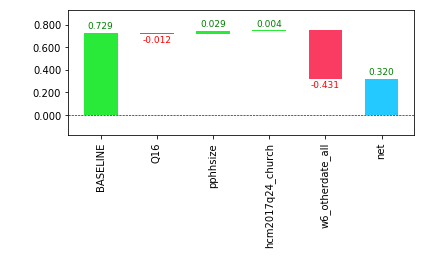

In [37]:
plot_variable_attribution(variables=["Q16", "pphhsize", "hcm2017q24_church", "w6_otherdate_all"],
                          vals=[12, 2, 0, 1], model=clf, X=X)

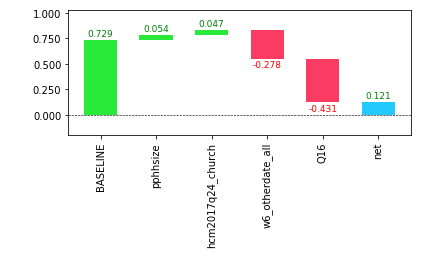

In [38]:
plot_variable_attribution(variables=["pphhsize", "hcm2017q24_church", "w6_otherdate_all", "Q16"],
                          vals=[2, 0, 1, 12], model=clf, X=X)

### Wnioski

Widać, że wartości wpływu poszczególnych zmiennych rzeczywiście zależą od kolejności warunkowania. W tym przypadku zmiana kolejności wpłynęła diametralnie na jedną spośród czterech rozważanych zmiennych. Warunkowanie Q16=12 na początku (rysunek pierwszy) powoduje delikatnie ujemny wpływ tej zmiennej na odpowiedź modelu, natomiast warunkowane jako ostatnie (rysunek drugi) zmniejsza odpowiedź modelu aż o 0.43. Wpływ zmiennej w6_otherdate_all również się zmienił przy zmianie kolejności warunkowania, jednak nie tak znacząco - najpierw wynosił -0.43, a następnie -0.28. Pozostałe zmienne nie wykazały większych zmian - ich wpływ na obu wykresach jest bliski zera, lecz dodatni.